In [46]:
import pandas as pd 
from rdkit import Chem
from path import Path

import sys
import os
cwd = os.getcwd()
parent_dir = os.path.dirname(cwd)
parent_parent_dir = os.path.dirname(parent_dir)

sys.path.append(parent_dir)
sys.path.append(parent_parent_dir)

from metrics_batch_created import calculate_uniqueness, calculate_novelty, calculate_validity, plot_molecule_sizes, plot_atom_distribution_dict, calculate_scores, plot_scores
from DataPipeline.preprocessing import smiles_to_torch_geometric, torch_geometric_to_networkx, plot_graph

In [47]:
zinc_path = Path('rndm_zinc_drugs_clean_3.csv')
zinc_df = pd.read_csv(zinc_path)

mol_path = Path('generated_molecules_10000_charged_kekulized.csv')
mol_df = pd.read_csv(mol_path)


In [48]:
mol_list = mol_df['SMILES'].to_list()

In [56]:
def convert_canonical_smiles(smiles):
    # remove stereochemistry
    mol = Chem.MolFromSmiles(smiles)
    Chem.RemoveStereochemistry(mol)
    return Chem.MolToSmiles(mol)

zinc_df['canonical_smiles'] = zinc_df['smiles'].apply(convert_canonical_smiles)

In [49]:
validity, valid_molecules = calculate_validity(mol_list)

[13:03:56] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:03:56] Explicit valence for atom # 20 N, 4, is greater than permitted
[13:03:57] Explicit valence for atom # 19 C, 5, is greater than permitted
[13:03:57] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:03:57] Explicit valence for atom # 2 Br, 3, is greater than permitted


In [50]:
# Non valid molecules

non_valid_molecules = [mol for mol in mol_list if mol not in valid_molecules]

In [51]:
validity

0.9995

In [52]:
uniqueness, unique_molecules = calculate_uniqueness(valid_molecules)

In [53]:
uniqueness

0.9998999499749875

In [54]:
unique_molecules_canonical = [convert_canonical_smiles(mol) for mol in unique_molecules]

In [57]:
novelty, non_new_mols = calculate_novelty(unique_molecules_canonical, zinc_df['canonical_smiles'].to_list())

100%|██████████| 9994/9994 [00:29<00:00, 334.06it/s]


In [58]:
non_new_mols

['CC1(C)CCCC1[NH2+]Cc1ccc(C(=O)[O-])cc1',
 'CCOc1cccc(C2C3=C(CCCC3=O)NC3=C2C(=O)CCC3)c1',
 'Cc1ccc(S(=O)(=O)Nc2ccc3c(c2)OCCCO3)cc1',
 'COc1ccc(C(O)c2cccc(F)c2)cc1OC',
 'Cc1cc(OCC(=O)NC(c2ccccc2)c2ccccc2)ccc1[N+](=O)[O-]',
 'COc1ccc(F)cc1NC(=O)NC1CCCCC1CO',
 'COc1ccc(C=C(C#N)c2nc3ccccc3s2)cc1',
 'CCOc1ccccc1C(=O)Nc1cc(C)nn1-c1ccccc1',
 'CC[NH+]=C(NCCc1ccccc1)NC1CC1C',
 'O=C(CS(=O)Cc1ccc(F)cc1)NCC(F)(F)F',
 'Cc1ccc(C=CC(=O)NCc2ccc([N+](=O)[O-])cc2)cc1',
 'CC1(O)CC2CCC1(C)C2(C)C',
 'CC(C)C[NH2+]C1CCOC2(CCCC2)C1',
 'CC(NC(=O)c1cnc(C2CCCO2)s1)c1ccncc1',
 'CCCC1CCC(C)CC1O',
 'O=C(CSc1nnc(-c2cccnc2)n1C1CC1)N1CCCC1']

In [77]:
Chem.MolFromSmiles(non_new_mols[16])

IndexError: list index out of range

In [60]:
novelty

0.9983990394236542

In [78]:
scores = calculate_scores(valid_molecules)

In [24]:
scores_zinc = calculate_scores(zinc_df['canonical_smiles'].to_list())

In [25]:
# Save scores zinc in a csv file

df_zinc = pd.DataFrame(scores_zinc, columns=['QED_score'])
df_zinc.to_csv('scores_zinc.csv', index=False)

In [79]:
# Load Zinc scores

scores_zinc_path = Path('scores_zinc.csv')
scores_zinc_df = pd.read_csv(scores_zinc_path)

In [80]:
scores_zinc = scores_zinc_df['QED_score'].to_list()

In [84]:
import numpy as np
from scipy.stats import entropy

def calculate_kl_divergence(list1, list2, bins=50):
    # Create histograms
    hist1, _ = np.histogram(list1, bins=bins, density=True)
    hist2, _ = np.histogram(list2, bins=bins, density=True)

    # Avoid division by zero
    hist1 += 1e-8
    hist2 += 1e-8

    # Compute KL divergence
    kl_div = entropy(hist1, hist2)

    return kl_div


In [82]:
def calculate_js_divergence(list1, list2, bins=2000):
    # Create histograms
    hist1, _ = np.histogram(list1, bins=bins, density=True)
    hist2, _ = np.histogram(list2, bins=bins, density=True)

    # Avoid division by zero
    hist1 += 1e-8
    hist2 += 1e-8

    # Compute mixed distribution
    mix = (hist1 + hist2) / 2

    # Compute JS divergence
    js_div = (entropy(hist1, mix) + entropy(hist2, mix)) / 2

    return js_div

In [85]:
calculate_kl_divergence(scores, scores_zinc)

0.00537276669846026

In [41]:
calculate_kl_divergence(scores_zinc, scores)

0.004083586583555253

In [45]:
calculate_js_divergence(scores, scores_zinc)

0.12025943762070967

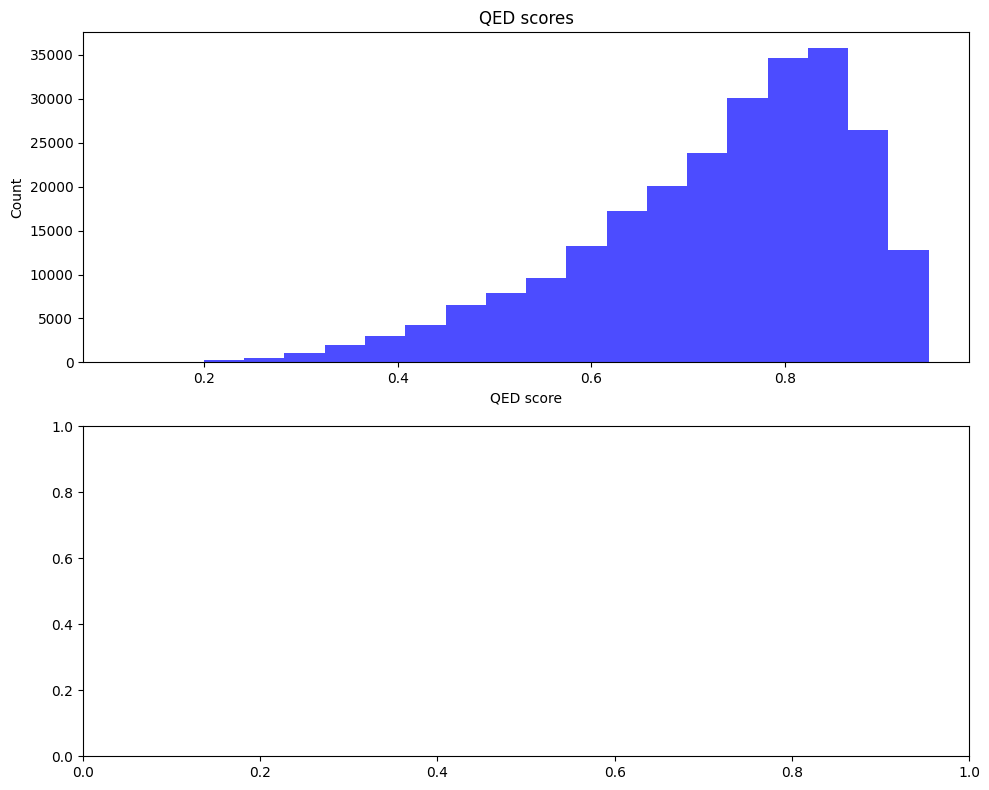

In [86]:
plot_scores(scores_zinc)

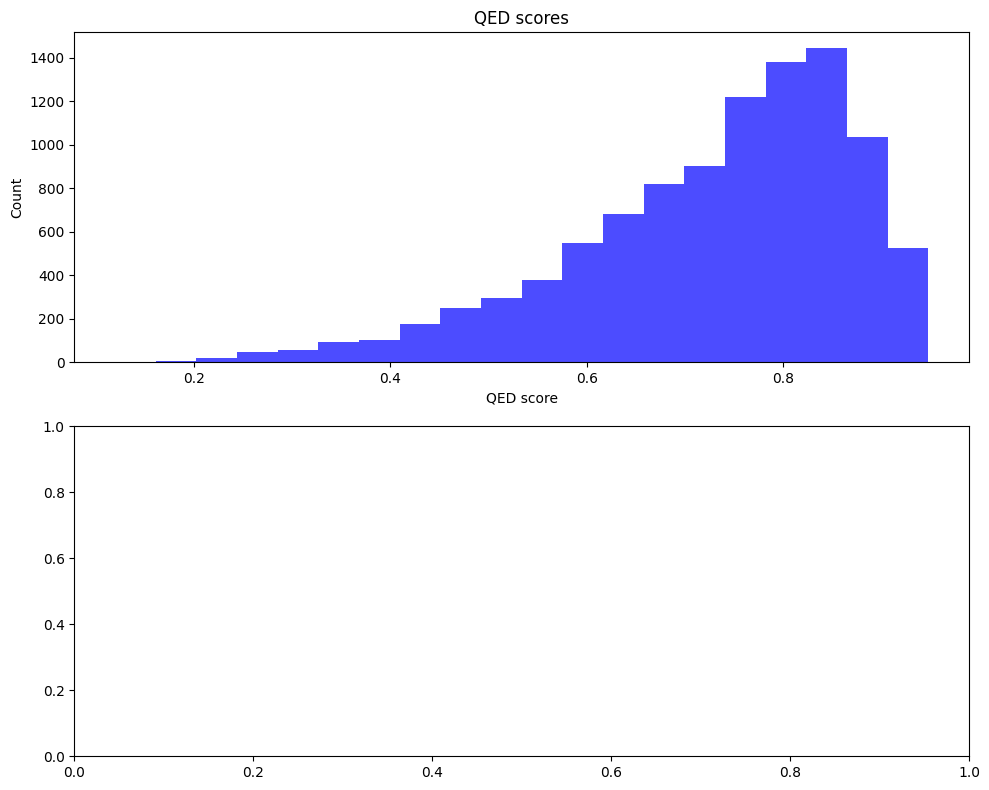

In [87]:
plot_scores(scores)

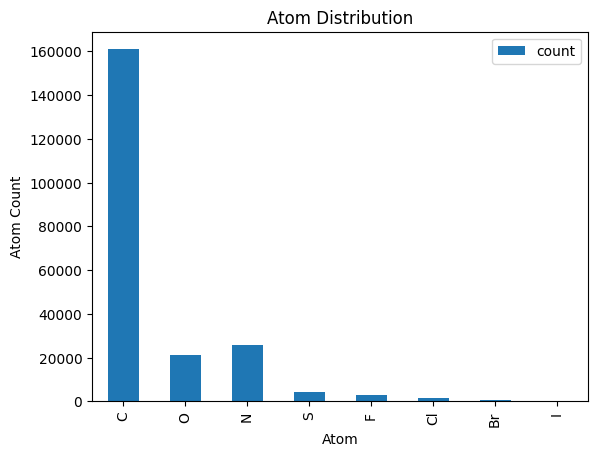

In [88]:
plot_atom_distribution_dict(valid_molecules)

In [20]:
plot_atom_distribution_dict(zinc_df['smiles'].to_list())

KeyboardInterrupt: 

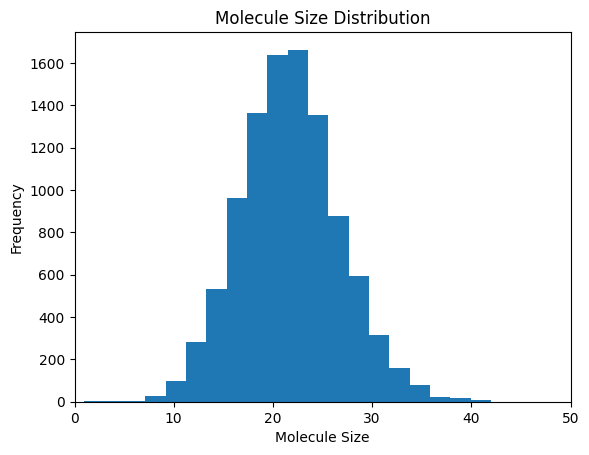

In [89]:
plot_molecule_sizes(valid_molecules)

In [90]:
def get_cycle_lengths(smiles):
    mol = Chem.MolFromSmiles(smiles)
    cycle_lengths = [len(cycle) for cycle in Chem.GetSymmSSSR(mol)]
    return cycle_lengths


df_valid = pd.DataFrame(valid_molecules, columns=['SMILES'])

df_valid['CycleLengths'] = df_valid['SMILES'].apply(get_cycle_lengths)


In [91]:
import matplotlib.pyplot as plt

# Plot histograms for cycle length in different rows of the same figure
def plot_histograms(data):
    fig, axs = plt.subplots(3, 2, figsize=(10, 10))
    axs[0, 0].hist(data['CycleLengths'].apply(lambda x: x.count(3)), bins=20)
    axs[0, 0].set_title('Cycle Length 3')
    axs[0, 1].hist(data['CycleLengths'].apply(lambda x: x.count(4)), bins=20)
    axs[0, 1].set_title('Cycle Length 4')
    axs[1, 0].hist(data['CycleLengths'].apply(lambda x: x.count(5)), bins=20)
    axs[1, 0].set_title('Cycle Length 5')
    axs[1, 1].hist(data['CycleLengths'].apply(lambda x: x.count(6)), bins=20)
    axs[1, 1].set_title('Cycle Length 6')
    axs[2, 0].hist(data['CycleLengths'].apply(lambda x: x.count(7)), bins=20)
    axs[2, 0].set_title('Cycle Length 7')
    axs[2, 1].hist(data['CycleLengths'].apply(lambda x: x.count(8)), bins=20)
    axs[2, 1].set_title('Cycle Length 8')
    plt.show()

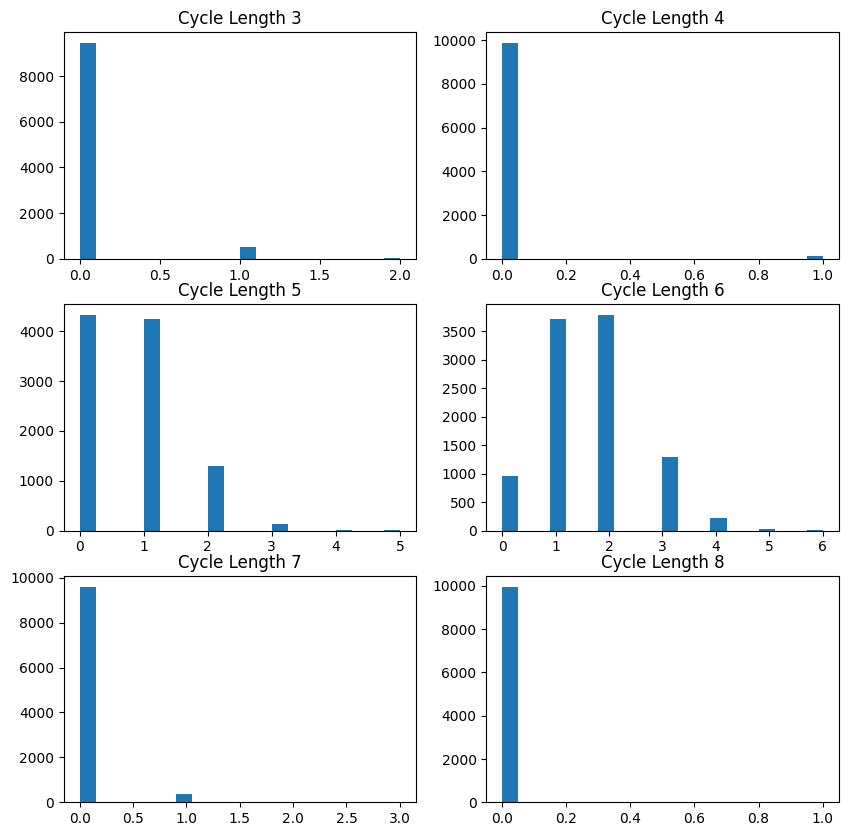

In [92]:
plot_histograms(df_valid)

In [93]:
from collections import Counter

def count_bonding_types(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return Counter([bond.GetBondType() for bond in mol.GetBonds()])

C:\Users\goupi\AppData\Local\Temp\ipykernel_17400\961120245.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_valid['BondingTypes'].apply(pd.Series).fillna(0).astype(int).sum().plot.bar()


<Axes: >

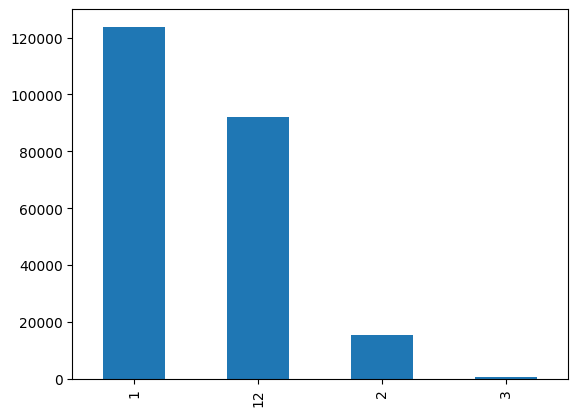

In [94]:
df_valid['BondingTypes'] = df_valid['SMILES'].apply(count_bonding_types)

#Plot 

df_valid['BondingTypes'].apply(pd.Series).fillna(0).astype(int).sum().plot.bar()